In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import requests

In [2]:
airbnb_data = pd.read_csv('../Input_data/Input Data.csv')
airbnb_df = pd.DataFrame(airbnb_data)
airbnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
# might make sense to calculate a minimum payment since price is per night and listings have a minimum night requirement
airbnb_df['min_price_to_stay'] = airbnb_df['price'] * airbnb_df['minimum_nights']

# keep the variables we believe to be useful
airbnb_df = airbnb_df[['host_id', 'id', 'neighbourhood_group','neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'min_price_to_stay',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']]

# limit to Brooklyn neighbourhood_group for analysis
brooklyn_df = airbnb_df.loc[airbnb_df['neighbourhood_group'] == 'Brooklyn']
brooklyn_df.head()

,host_id,id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,min_price_to_stay,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,2539,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,149,9,0.21,6,365
3,4869,3831,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,89,270,4.64,1,194
6,7356,5121,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,2700,49,0.40,1,0
12,9744,5803,Brooklyn,South Slope,40.66829,-73.98779,Private room,89,4,356,167,1.34,3,314
15,15991,6848,Brooklyn,Williamsburg,40.70837,-73.95352,Entire home/apt,140,2,280,148,1.20,1,46


In [4]:
# see how many records there are prior to cleaning/outlier removal
len(brooklyn_df)

20104

last_review and reviews_per_month are missing values compared to the rest of the data
likely due to listings have zero reviews...

In [5]:
brooklyn_df.count()

host_id                           20104
id                                20104
neighbourhood_group               20104
neighbourhood                     20104
latitude                          20104
longitude                         20104
room_type                         20104
price                             20104
minimum_nights                    20104
min_price_to_stay                 20104
number_of_reviews                 20104
reviews_per_month                 16447
calculated_host_listings_count    20104
availability_365                  20104
dtype: int64

In [6]:
brooklyn_df['reviews_per_month'].fillna(0)
brooklyn_df.count()

host_id                           20104
id                                20104
neighbourhood_group               20104
neighbourhood                     20104
latitude                          20104
longitude                         20104
room_type                         20104
price                             20104
minimum_nights                    20104
min_price_to_stay                 20104
number_of_reviews                 20104
reviews_per_month                 16447
calculated_host_listings_count    20104
availability_365                  20104
dtype: int64

In [7]:
min_nights_brooklyn_quartiles = brooklyn_df['minimum_nights'].quantile([.25,.5,.75])
min_nights_lowerq = min_nights_brooklyn_quartiles[.25]
min_nights_upperq = min_nights_brooklyn_quartiles[.75]
min_nights_iqr = (min_nights_upperq-min_nights_lowerq).round(2)
min_nights_low_b = (min_nights_lowerq - (1.5*min_nights_iqr)).round(2)
print(f'lower bound for minimum nights is {min_nights_low_b}')
min_nights_up_b = (min_nights_upperq + (1.5*min_nights_iqr)).round(2)
print(f'upper bound for minimum nights is {min_nights_up_b}')

price_brooklyn_quartiles = brooklyn_df['price'].quantile([.25,.5,.75])
price_lowerq = price_brooklyn_quartiles[.25]
price_upperq = price_brooklyn_quartiles[.75]
price_iqr = (price_upperq-price_lowerq).round(2)
price_low_b = (price_lowerq - (1.5*price_iqr)).round(2)
print(f'lower bound for price is {price_low_b}')
price_up_b = (price_upperq + (1.5*price_iqr)).round(2)
print(f'upper bound for price is {price_up_b}')

lower bound for minimum nights is -2.5
upper bound for minimum nights is 9.5
lower bound for price is -75.0
upper bound for price is 285.0


In [8]:
brooklyn_cleaned_df = brooklyn_df.loc[(brooklyn_df['price'] <= 285) & (brooklyn_df['minimum_nights'] < 10) & (brooklyn_df['number_of_reviews'] > 0)]
brooklyn_cleaned_df.head()

,host_id,id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,min_price_to_stay,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,2539,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,149,9,0.21,6,365
3,4869,3831,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,89,270,4.64,1,194
12,9744,5803,Brooklyn,South Slope,40.66829,-73.98779,Private room,89,4,356,167,1.34,3,314
15,15991,6848,Brooklyn,Williamsburg,40.70837,-73.95352,Entire home/apt,140,2,280,148,1.20,1,46
16,17571,7097,Brooklyn,Fort Greene,40.69169,-73.97185,Entire home/apt,215,2,430,198,1.72,1,321


In [9]:
# going from 20104 listings to 14117 after removing outliers and only looking at those with reviews
len(brooklyn_cleaned_df)

14117

In [10]:
# establish bins for price so we can categorize the neighbourhood and room type
price_bins = [0,49.9,99.9,149.9,249.9,10001]
price_bin_names = ['0-49','50-99','100-149','150-249','>250']
brooklyn_room_info = brooklyn_cleaned_df.loc[:,['neighbourhood','room_type','number_of_reviews','minimum_nights','price','min_price_to_stay']]
brooklyn_room_info['price range'] = pd.cut(brooklyn_room_info['price'],price_bins,labels=price_bin_names)

brooklyn_neighbourhoods = brooklyn_room_info.groupby(['neighbourhood', 'room_type', 'price range']).agg(['count', 'mean', 'min', 'max'])
brooklyn_neighbourhoods = brooklyn_neighbourhoods.sort_values(by=('number_of_reviews', 'count'), ascending=False)
brooklyn_neighbourhoods.sort_values(by=('number_of_reviews', 'count'), ascending=False).head(20)

number_of_reviews             \
                                                           count       mean   
neighbourhood      room_type       price range                                
Williamsburg       Private room    50-99                    1065  27.885446   
Bedford-Stuyvesant Private room    50-99                     972  32.290123   
Bushwick           Private room    50-99                     778  27.156812   
Williamsburg       Entire home/apt 150-249                   645  30.817054   
Bedford-Stuyvesant Entire home/apt 100-149                   526  56.357414   
                                   150-249                   401  44.992519   
Bushwick           Private room    0-49                      377  19.824934   
Bedford-Stuyvesant Private room    0-49                      363  22.528926   
Crown Heights      Private room    50-99                     350  31.388571   
Williamsburg       Entire home/apt 100-149                   328  25.707317   
Bedford-Stuyvesant Entire home/apt 50-99                     280  40.289286   
Williamsburg       Private room    100-149                   219  36.237443   
Crown Heights      Entire home/apt 100-149                   218  34.761468   
Greenpoint         Private room    50-99                     213  24.136150   
Bushwick           Entire home/apt 100-149                   198  42.772727   
Greenpoint         Entire home/apt 150-249                   172  30.203488   
Crown Heights      Entire home/apt 150-249                   160  36.912500   
Flatbush           Private room    50-99                     147  30.170068   
Crown Heights      Entire home/apt 50-99                     145  26.358621   
Bushwick           Entire home/apt 150-249                   145  34.868966   

                                                           minimum_nights  \
                                                min    max          count   
neighbourhood      room_type       price range                              
Williamsburg       Private room    50-99        1.0  349.0           1065   
Bedford-Stuyvesant Private room    50-99        1.0  397.0            972   
Bushwick           Private room    50-99        1.0  480.0            778   
Williamsburg       Entire home/apt 150-249      1.0  404.0            645   
Bedford-Stuyvesant Entire home/apt 100-149      1.0  350.0            526   
                                   150-249      1.0  370.0            401   
Bushwick           Private room    0-49         1.0  251.0            377   
Bedford-Stuyvesant Private room    0-49         1.0  174.0            363   
Crown Heights      Private room    50-99        1.0  247.0            350   
Williamsburg       Entire home/apt 100-149      1.0  385.0            328   
Bedford-Stuyvesant Entire home/apt 50-99        1.0  268.0            280   
Williamsburg       Private room    100-149      1.0  374.0            219   
Crown Heights      Entire home/apt 100-149      1.0  349.0            218   
Greenpoint         Private room    50-99        1.0  241.0            213   
Bushwick           Entire home/apt 100-149      1.0  308.0            198   
Greenpoint         Entire home/apt 150-249      1.0  248.0            172   
Crown Heights      Entire home/apt 150-249      1.0  233.0            160   
Flatbush           Private room    50-99        1.0  219.0            147   
Crown Heights      Entire home/apt 50-99        1.0  225.0            145   
Bushwick           Entire home/apt 150-249      1.0  254.0            145   

                                                                   price  \
                                                    mean  min  max count   
neighbourhood      room_type       price range                             
Williamsburg       Private room    50-99        2.633803  1.0  9.0  1065   
Bedford-Stuyvesant Private room    50-99        2.350823  1.0  9.0   972   
Bushwick           Private room    50-99        2.327763  1.0  9.0   778   
W

In [11]:
# order the neighborhoods by number of listings
brooklyn_neighbourhood_by_popularity = []

for row in brooklyn_neighbourhoods.head(25).index:
    if row[0] not in brooklyn_neighbourhood_by_popularity:
        brooklyn_neighbourhood_by_popularity.append(row[0])

brooklyn_neighbourhood_listing_count = []


for n in brooklyn_neighbourhood_by_popularity:
    count = len(brooklyn_df.loc[brooklyn_df['neighbourhood'] == n])
    brooklyn_neighbourhood_listing_count.append(count)

listing_count_by_neighbourhood_df = pd.DataFrame({
    'neighbourhood': brooklyn_neighbourhood_by_popularity,
    'count': brooklyn_neighbourhood_listing_count
})

listing_count_by_neighbourhood_df = listing_count_by_neighbourhood_df.sort_values(by='count', ascending=False)
listing_count_by_neighbourhood_df

,neighbourhood,count
0,Williamsburg,3920
1,Bedford-Stuyvesant,3714
2,Bushwick,2465
3,Crown Heights,1564
4,Greenpoint,1115
5,Flatbush,621
6,Prospect-Lefferts Gardens,535


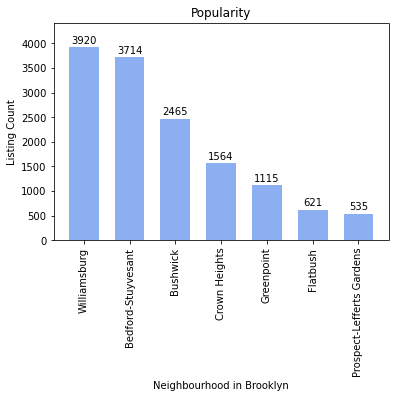

In [14]:
fig, ax = plt.subplots()

x_axis = np.arange(len(brooklyn_neighbourhood_by_popularity))

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, listing_count_by_neighbourhood_df['neighbourhood'], rotation=90)

y_axis = listing_count_by_neighbourhood_df['count']


rects1 = ax.bar(x_axis, y_axis, color="cornflowerblue", alpha=0.75, align="center",  width=0.65)

ax.set_ylabel('Listing Count')
ax.set_title('Popularity')
ax.set_xlabel('Neighbourhood in Brooklyn')
ax.set_ylim(0,max(brooklyn_neighbourhood_listing_count)+500)


def autolabel(rects):
    # Attach a text label above each bar in *rects*, displaying its height.
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
plt.savefig(f'../Visualization/Brooklyn_Popularity_by_Listing_Count.png')

plt.show()

In [15]:
# take the top 25 neighbourhoods
neighbourhood_by_price = brooklyn_neighbourhoods.head(25)

neighbourhood_by_price = neighbourhood_by_price.reset_index()

worth_per_stay = []

for i in range(len(neighbourhood_by_price)):
    if neighbourhood_by_price['room_type'][i] == 'Private room':
        # if it the listing is a private room, we will assume that there are two rooms available to list
        worth_per_stay.append(neighbourhood_by_price.loc[:, ('min_price_to_stay', 'mean')][i]*2)
    else:
        worth_per_stay.append(neighbourhood_by_price.loc[:, ('min_price_to_stay', 'mean')][i])
    
neighbourhood_by_price['worth_per_stay'] = worth_per_stay
neighbourhood_by_price

neighbourhood        room_type price range number_of_reviews  \
                                                                       count   
0                Williamsburg     Private room       50-99              1065   
1          Bedford-Stuyvesant     Private room       50-99               972   
2                    Bushwick     Private room       50-99               778   
3                Williamsburg  Entire home/apt     150-249               645   
4          Bedford-Stuyvesant  Entire home/apt     100-149               526   
5          Bedford-Stuyvesant  Entire home/apt     150-249               401   
6                    Bushwick     Private room        0-49               377   
7          Bedford-Stuyvesant     Private room        0-49               363   
8               Crown Heights     Private room       50-99               350   
9                Williamsburg  Entire home/apt     100-149               328   
10         Bedford-Stuyvesant  Entire home/apt       50-99               280   
11               Williamsburg     Private room     100-149               219   
12              Crown Heights  Entire home/apt     100-149               218   
13                 Greenpoint     Private room       50-99               213   
14                   Bushwick  Entire home/apt     100-149               198   
15                 Greenpoint  Entire home/apt     150-249               172   
16              Crown Heights  Entire home/apt     150-249               160   
17                   Flatbush     Private room       50-99               147   
18              Crown Heights  Entire home/apt       50-99               145   
19                   Bushwick  Entire home/apt     150-249               145   
20              Crown Heights     Private room        0-49               142   
21                   Bushwick  Entire home/apt       50-99               136   
22                 Greenpoint  Entire home/apt     100-149               130   
23               Williamsburg  Entire home/apt        >250               121   
24  Prospect-Lefferts Gardens     Private room       50-99               116   

                          minimum_nights                     price  \
         mean  min    max          count      mean  min  max count   
0   27.885446  1.0  349.0           1065  2.633803  1.0  9.0  1065   
1   32.290123  1.0  397.0            972  2.350823  1.0  9.0   972   
2   27.156812  1.0  480.0            778  2.327763  1.0  9.0   778   
3   30.817054  1.0  404.0            645  2.838760  1.0  9.0   645   
4   56.357414  1.0  350.0            526  2.878327  1.0  9.0   526   
5   44.992519  1.0  370.0            401  2.852868  1.0  9.0   401   
6   19.824934  1.0  251.0            377  2.472149  1.0  9.0   377   
7   22.528926  1.0  174.0            363  2.550964  1.0  8.0   363   
8   31.388571  1.0  247.0            350  2.234286  1.0  7.0   350   
9   25.707317  1.0  385.0            328  3.219512  1.0  9.0   328   
10  40.289286  1.0  268.0            280  2.903571  1.0  8.0   280   
11  36.237443  1.0  374.0            219  2.342466  1.0  7.0   219   
12  34.761468  1.0  349.0            218  2.839450  1.0  7.0   218   
13  24.136150  1.0  241.0            213  2.957746  1.0  8.0   213   
14  42.772727  1.0  308.0            198  2.762626  1.0  7.0   198   
15  30.203488  1.0  248.0            172  2.843023  1.0  8.0   172   
16  36.912500  1.0  233.0            160  2.812500  1.0  7.0   160   
17  30.170068  1.0  219.0            147  2.272109  1.0  7.0   147   
18  26.358621  1.0  225.0            145  3.255172  1.0  9.0   145   
19  34.868966  1.0  254.0            145  2.737931  1.0  9.0   145   
20  22.760563  1.0  165.0            142  2.774648  1.0  8.0   142   
21  38.235294  1.0  231.0            136  2.963235  1.0  9.0   136   
22  26.007692  1.0  328.0            130  3.115385  1.0  8.0   130   
23  29.140496  1.0  222.0            121  2.801653  1.0  8.0   121   
24  41.706897  1.0  229.0          

In [16]:
# Create a list of the neighbourhoods in the top 25 listings
brooklyn_neighbourhood_by_worth = []

for neighbourhood in neighbourhood_by_price['neighbourhood']:
    if neighbourhood not in brooklyn_neighbourhood_by_worth:
        brooklyn_neighbourhood_by_worth.append(neighbourhood)
        
brooklyn_neighbourhood_by_worth;

# Put together a measure of total profitability for each neighbourhood
    
brooklyn_neighbourhood_worth_per_stay = []

for neighbourhood in brooklyn_neighbourhood_by_worth:
    price = sum(neighbourhood_by_price.loc[neighbourhood_by_price['neighbourhood'] == neighbourhood, 'worth_per_stay'])
    brooklyn_neighbourhood_worth_per_stay.append(price)

brooklyn_neighbourhood_worth_per_stay

worth_per_stay_by_neighbourhood_df = pd.DataFrame({
    'neighbourhood': brooklyn_neighbourhood_by_worth,
    'Worth per Stay': brooklyn_neighbourhood_worth_per_stay
})

worth_per_stay_by_neighbourhood_df = worth_per_stay_by_neighbourhood_df.sort_values(by='Worth per Stay', ascending=False)
worth_per_stay_by_neighbourhood_df


,neighbourhood,Worth per Stay
0,Williamsburg,2553.178788
3,Crown Heights,1623.476259
1,Bedford-Stuyvesant,1611.880624
2,Bushwick,1577.500863
4,Greenpoint,1317.900738
5,Flatbush,299.632653
6,Prospect-Lefferts Gardens,283.465517


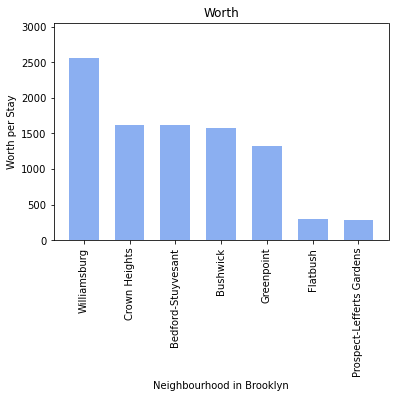

In [17]:
fig, ax = plt.subplots()

x_axis = np.arange(len(brooklyn_neighbourhood_by_worth))

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, worth_per_stay_by_neighbourhood_df['neighbourhood'], rotation=90)

y_axis = round(worth_per_stay_by_neighbourhood_df['Worth per Stay'], 2)


rects1 = ax.bar(x_axis, y_axis, color="cornflowerblue", alpha=0.75, align="center",  width=0.65)

ax.set_ylabel('Worth per Stay')
ax.set_title('Worth')
ax.set_xlabel('Neighbourhood in Brooklyn')
ax.set_ylim(0,max(brooklyn_neighbourhood_worth_per_stay)+500)


#def autolabel(rects):
#     # Attach a text label above each bar in *rects*, displaying its height.
#    for rect in rects:
#        height = rect.get_height()
#        ax.annotate('{}'.format(height),
#                    xy=(rect.get_x() + rect.get_width() / 2, height),
#                    xytext=(0, 2),  
#                    textcoords="offset points",
#                    ha='center', va='bottom')


#autolabel(rects1)
plt.savefig(f'../Visualization/Brooklyn_Worth_per_Stay.png')

plt.show()

### Top 5 neighbourhoods in Brooklyn by listing
1. Williamsburg: 3920
2. Bedford-Stuyvesant: 3714
3. Bushwick: 2465
4. Crown Heights: 1564
5. Greenpoint: 1115

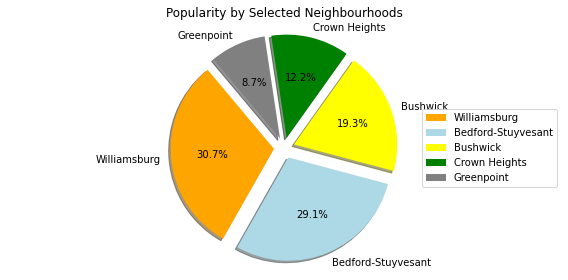

In [18]:
pie_chart_df = listing_count_by_neighbourhood_df.reset_index(drop=True)

pie_chart_df

# We are going to look at the top five neighbourhoods by listing only
pie_chart_df = pie_chart_df.loc[0:4, :]

fig, ax = plt.subplots(figsize=(8, 4), subplot_kw=dict(aspect="equal"))

neigh_list = pie_chart_df['neighbourhood']
length = len(pie_chart_df['neighbourhood'])

x_axis = np.arange(length)

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, neigh_list, rotation=90)

y_axis = pie_chart_df['count']

explode = (0.1,0.1,0.1,0.1,0.1)
colors = ["orange","lightblue", "yellow", "green", "grey"]

ax.pie(y_axis, explode=explode, labels=neigh_list, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=130)

ax.set_title("Popularity by Selected Neighbourhoods")
ax.legend(loc="center right")

plt.axis("equal")

fig.tight_layout()
plt.savefig(f'../Visualization/Brooklyn_Popularity_by_Selected_Neighbourhoods.png')
plt.show()

In [19]:
profitability_df = worth_per_stay_by_neighbourhood_df.reset_index(drop=True)

profitability_df = profitability_df.loc[0:4, :]

profitability = []

for i in range(len(profitability_df['Worth per Stay'])):
    profitability.append(profitability_df['Worth per Stay'][i] * (pie_chart_df['count'][i] / sum(pie_chart_df['count'])))

profitability_df['Listings'] = pie_chart_df['count']
profitability_df['Profitability'] = profitability

profitability_df = profitability_df.sort_values(by='Profitability', ascending=False)

profitability_df

,neighbourhood,Worth per Stay,Listings,Profitability
0,Williamsburg,2553.178788,3920,783.257227
1,Crown Heights,1623.476259,3714,471.872815
2,Bedford-Stuyvesant,1611.880624,2465,310.947389
3,Bushwick,1577.500863,1564,193.082748
4,Greenpoint,1317.900738,1115,114.999164


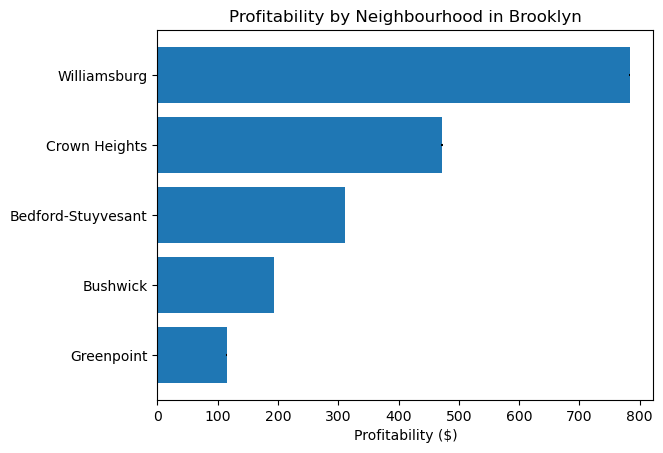

In [20]:
y_axis = profitability_df['neighbourhood'].values
x_axis = profitability_df['Profitability'].values


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data

y_pos = np.arange(len(y_axis))
error = np.random.rand(len(y_axis))

ax.barh(y_pos, x_axis, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_axis)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Profitability ($)')
ax.set_title('Profitability by Neighbourhood in Brooklyn')

plt.savefig(f'../Visualization/Brooklyn_Profitability_by_Neighbourhood.png')

plt.show()


In [19]:
bronx_crime_df = airbnb_df.loc[airbnb_df['neighbourhood_group'] == 'Bronx']

manhattan_crime_df = airbnb_df.loc[airbnb_df['neighbourhood_group'] == 'Manhattan']

queens_crime_df = airbnb_df.loc[airbnb_df['neighbourhood_group'] == 'Queens']

brooklyn_crime_df = airbnb_df.loc[airbnb_df['neighbourhood_group'] == 'Brooklyn']

staten_island_crime_df = airbnb_df.loc[airbnb_df['neighbourhood_group'] == 'Staten Island']

In [20]:
bronx_sample_crime_df = bronx_crime_df.sample(n=100, replace=True)
manhattan_sample_crime_df = manhattan_crime_df.sample(n=100, replace=True)
queens_sample_crime_df = queens_crime_df.sample(n=100, replace=True)
brooklyn_sample_crime_df = brooklyn_crime_df.sample(n=100, replace=True)
staten_island_sample_crime_df = staten_island_crime_df.sample(n=100, replace=True)


bronx_sample_crime_df = bronx_sample_crime_df.reset_index(drop=True)
manhattan_sample_crime_df = manhattan_sample_crime_df.reset_index(drop=True)
queens_sample_crime_df = queens_sample_crime_df.reset_index(drop=True)
brooklyn_sample_crime_df = brooklyn_sample_crime_df.reset_index(drop=True)
staten_island_sample_crime_df = staten_island_sample_crime_df.reset_index(drop=True)

In [139]:
crime_df_sample_list = [bronx_sample_crime_df, manhattan_sample_crime_df, queens_sample_crime_df, brooklyn_sample_crime_df, staten_island_sample_crime_df]

neighbourhoods = ['Bronx', 'Manhattan', 'Queens', 'Brooklyn', 'Staten Island']
crime_numbers = []

for sample in crime_df_sample_list:
    for index, row in sample.iterrows():
        neighbourhood = row["neighbourhood"]
        neighbourhood_group = row["neighbourhood_group"]
        print(f'Looking for crime rate in index no:{index} | {neighbourhood} | {neighbourhood_group}')
        lat = row["latitude"]
        lng = row["longitude"]
        url = 'https://data.cityofnewyork.us/resource/qb7u-rbmr.json?$where=within_circle'
        query_url = url + f"(lat_lon, {lat}, {lng}, 2000)"
    
        response = requests.get(query_url)
        data = response.json()
    
        try:
            sample.loc[index,'Number of Crimes'] = len(data)

        except:
            print(f"missing value for row number {index}")
    print(f"Total Number of Crimes in {neighbourhood_group}: {sum(sample['Number of Crimes'])}")
    crime_numbers.append(sum(sample['Number of Crimes']))
    
print(f"------------------------------------------------------------------------")
print(f"Data retrieval complete.")

Looking for crime rate in index no:0 | Throgs Neck | Bronx
Looking for crime rate in index no:1 | Morrisania | Bronx
Looking for crime rate in index no:2 | City Island | Bronx
Looking for crime rate in index no:3 | Van Nest | Bronx
Looking for crime rate in index no:4 | Edenwald | Bronx
Looking for crime rate in index no:5 | Kingsbridge | Bronx
Looking for crime rate in index no:6 | Concourse | Bronx
Looking for crime rate in index no:7 | Mott Haven | Bronx
Looking for crime rate in index no:8 | Claremont Village | Bronx
Looking for crime rate in index no:9 | Belmont | Bronx
Looking for crime rate in index no:10 | Mount Eden | Bronx
Looking for crime rate in index no:11 | Parkchester | Bronx
Looking for crime rate in index no:12 | Kingsbridge | Bronx
Looking for crime rate in index no:13 | Port Morris | Bronx
Looking for crime rate in index no:14 | Van Nest | Bronx
Looking for crime rate in index no:15 | Allerton | Bronx
Looking for crime rate in index no:16 | Eastchester | Bronx
Looki

Looking for crime rate in index no:35 | Midtown | Manhattan
Looking for crime rate in index no:36 | SoHo | Manhattan
Looking for crime rate in index no:37 | East Village | Manhattan
Looking for crime rate in index no:38 | Harlem | Manhattan
Looking for crime rate in index no:39 | Harlem | Manhattan
Looking for crime rate in index no:40 | Kips Bay | Manhattan
Looking for crime rate in index no:41 | Upper East Side | Manhattan
Looking for crime rate in index no:42 | Lower East Side | Manhattan
Looking for crime rate in index no:43 | Upper East Side | Manhattan
Looking for crime rate in index no:44 | Theater District | Manhattan
Looking for crime rate in index no:45 | Upper West Side | Manhattan
Looking for crime rate in index no:46 | Midtown | Manhattan
Looking for crime rate in index no:47 | NoHo | Manhattan
Looking for crime rate in index no:48 | East Harlem | Manhattan
Looking for crime rate in index no:49 | Upper West Side | Manhattan
Looking for crime rate in index no:50 | Midtown |

Looking for crime rate in index no:66 | Ridgewood | Queens
Looking for crime rate in index no:67 | Long Island City | Queens
Looking for crime rate in index no:68 | Glendale | Queens
Looking for crime rate in index no:69 | Astoria | Queens
Looking for crime rate in index no:70 | Astoria | Queens
Looking for crime rate in index no:71 | Astoria | Queens
Looking for crime rate in index no:72 | Astoria | Queens
Looking for crime rate in index no:73 | Long Island City | Queens
Looking for crime rate in index no:74 | Jamaica | Queens
Looking for crime rate in index no:75 | Flushing | Queens
Looking for crime rate in index no:76 | Elmhurst | Queens
Looking for crime rate in index no:77 | Long Island City | Queens
Looking for crime rate in index no:78 | Jamaica Estates | Queens
Looking for crime rate in index no:79 | Ditmars Steinway | Queens
Looking for crime rate in index no:80 | Woodside | Queens
Looking for crime rate in index no:81 | Astoria | Queens
Looking for crime rate in index no:82 

Looking for crime rate in index no:95 | Sunset Park | Brooklyn
Looking for crime rate in index no:96 | Bushwick | Brooklyn
Looking for crime rate in index no:97 | Windsor Terrace | Brooklyn
Looking for crime rate in index no:98 | Greenpoint | Brooklyn
Looking for crime rate in index no:99 | Bedford-Stuyvesant | Brooklyn
Total Number of Crimes in Brooklyn: 0.0
Looking for crime rate in index no:0 | Concord | Staten Island
Looking for crime rate in index no:1 | Stapleton | Staten Island
Looking for crime rate in index no:2 | Grymes Hill | Staten Island
Looking for crime rate in index no:3 | West Brighton | Staten Island
Looking for crime rate in index no:4 | Arrochar | Staten Island
Looking for crime rate in index no:5 | Tompkinsville | Staten Island
Looking for crime rate in index no:6 | West Brighton | Staten Island
Looking for crime rate in index no:7 | St. George | Staten Island
Looking for crime rate in index no:8 | St. George | Staten Island
Looking for crime rate in index no:9 | T

In [140]:
crime_df = pd.DataFrame({'Neighbourhood': neighbourhoods,
                         'Total Crime Number': crime_numbers
                        })

crime_df = crime_df.sort_values(by='Total Crime Number', ascending=False)
crime_df

,Neighbourhood,Total Crime Number
1,Manhattan,335.0
0,Bronx,19.0
2,Queens,4.0
3,Brooklyn,0.0
4,Staten Island,0.0
